notebook to plot boundary conditions from `NT_BC` and compare to Geant simulations

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:.5e}')

In [61]:
def plottable(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]

def plottable_spectrum(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]/abs(X[1:] - X[:-1])

def trap(x,y):
    return ((y[:-1] + y[1:])*(x[1:] - x[:-1])).sum()/2

def trap_plottable(X, Y):
    return Y.sum()

def trap_plottable_old(X, Y):
    x, y = plottable_spectrum(X,Y)
    return trap(x[::-1], y[::-1])

In [62]:
# energy bounds (eV)
EG = 0.1 
E0 = 2e7

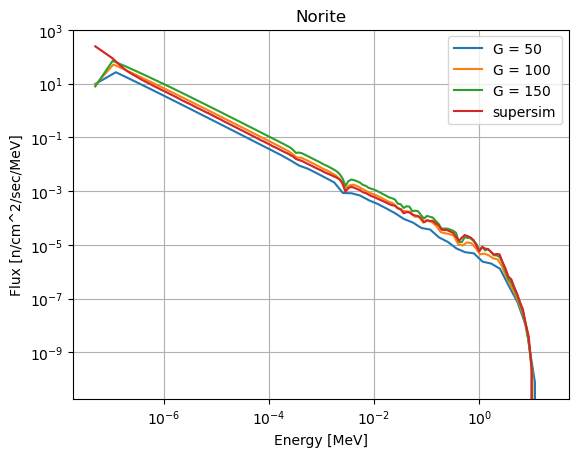

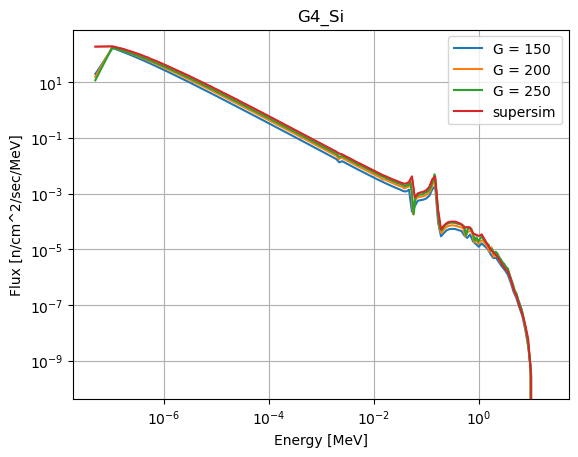

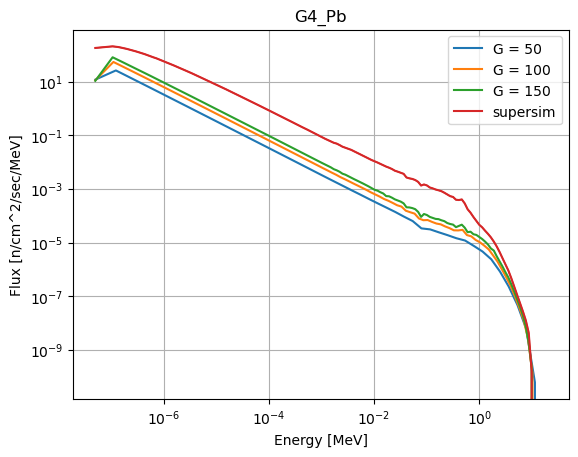

In [63]:
for mat in ['Norite', 'G4_Si', 'G4_Pb']:

    mat_str_add = '' if mat == 'Norite' else mat[2:]

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '_150.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])

    gs_s = ss_dat.index

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Flux [n/cm^2/sec/MeV]')
    plt.title(mat)

    for G in [50, 100, 150]:
        G += 100*(mat=='G4_Si')
        data_file = f'data/V1/data_{mat}_{G}_BC_V1.dat'
        dat = pd.read_csv(data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = dat.Eg.values
        phig = dat.phig.values
        gs = dat.index

        plt.plot(*plottable_spectrum(Eg, phig), label = f'G = {G}')

    Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
    _, dphig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.dphig.values)
    ss_plot = plt.plot(Eg_s, phig_s, label = 'supersim')
    plt.fill_between(Eg_s, phig_s - dphig_s, phig_s + dphig_s, alpha =  0.5, color = ss_plot[0].get_color())
    #plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

    plt.legend()

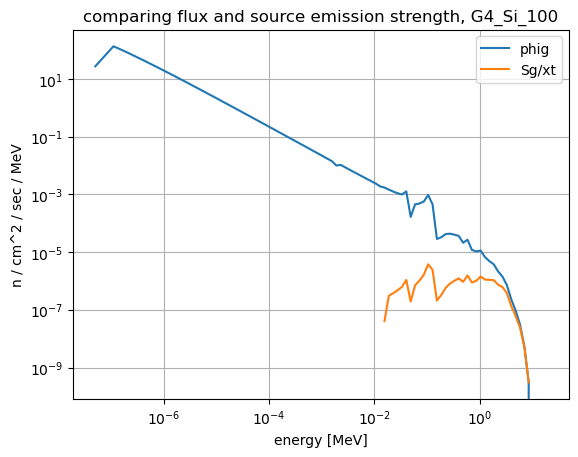

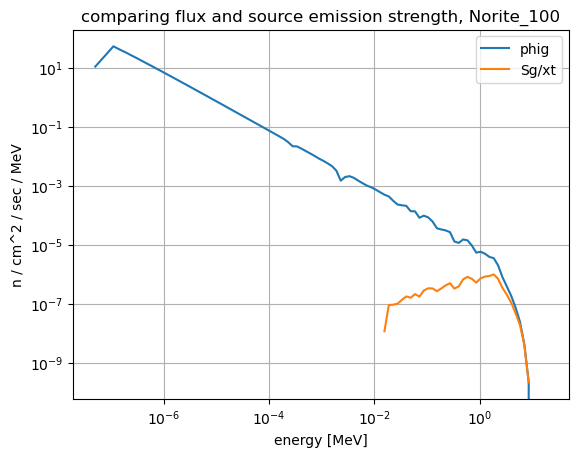

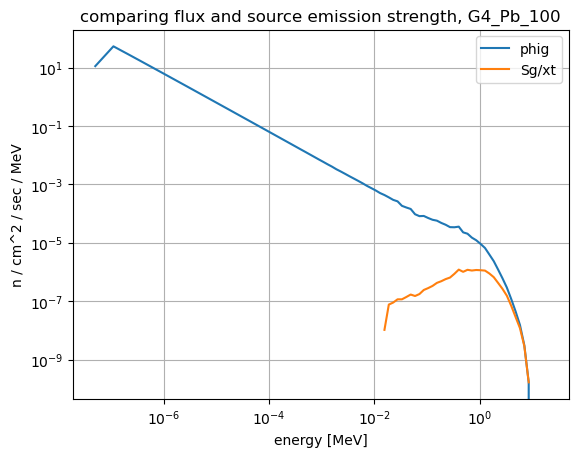

In [64]:
# compare flux and emission strength (group source/group total cross section)

for mat, G in [('G4_Si', 100), ('Norite', 100), ('G4_Pb', 100)]:

    XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'xt'])
    Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
    BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

    Eg = BC.Eg.values
    Es = (Eg[1:] + Eg[:-1])/2
    dE = abs(Eg[1:] - Eg[:-1])

    phig = BC.phig.values[:-1]/dE
    Sg = Src.Sg.values[:-1]/dE
    xt = XS.xt.values[:-1]
    xs = XS.x_s.values[:-1]

    p2 = Sg!=0

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('energy [MeV]')
    plt.ylabel('n / cm^2 / sec / MeV')
    plt.title(f'comparing flux and source emission strength, {mat}_{G}')

    plt.plot(Es, phig, label = 'phig')
    plt.plot(Es[p2], Sg[p2]/xt[p2], label = 'Sg/xt')


    plt.legend()

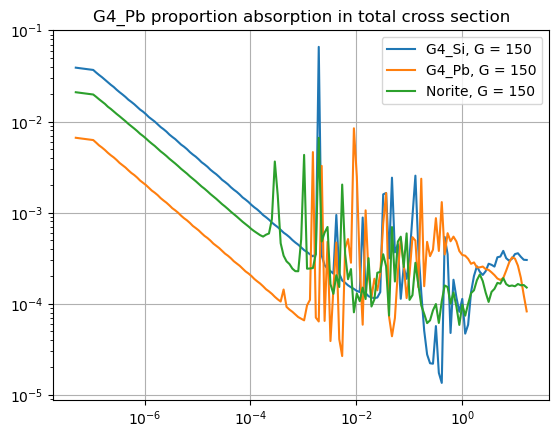

In [65]:
plt.figure()
plt.title(f'{mat} proportion absorption in total cross section')
plt.loglog()
plt.grid()

G = 150

for mat in ('G4_Si', 'G4_Pb', 'Norite'):
    XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'xt'])

    Eg = XS.Eg.values
    Es = (Eg[1:] + Eg[:-1])/2
    xt = XS.xt.values[:-1]
    xs = XS.x_s.values[:-1]

    plt.plot(Es[xt>0], (xt-xs)[xt>0]/xt[xt>0], label = f'{mat}, G = {G}')

plt.legend()

Text(0.5, 1.0, 'Relative uncertainty in Supersim flux')

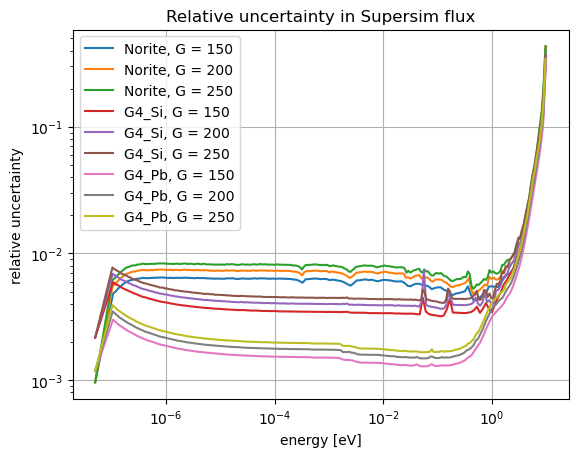

In [66]:
plt.figure()
plt.loglog()
plt.grid()

for mat in ['Norite', 'G4_Si', 'G4_Pb']:

    for G in (150, 200, 250):
        
        mat_str_add = '' if mat == 'Norite' else mat[2:]

        ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + f'_{G}.dat'
        ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])
        Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
        _, dphig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.dphig.values)
        
        p = dphig_s > 0
        plt.plot(Eg_s[p], dphig_s[p]/phig_s[p], label = f'{mat}, G = {G}')

plt.legend()
plt.xlabel('energy [eV]')
plt.ylabel('relative uncertainty')
plt.title('Relative uncertainty in Supersim flux')

In [67]:
A_vals = {'G4_Si': 28,
          'Norite': 20.86,
          'G4_Pb': 207}

def calc_bc(xs, xt, Sg):
    phi = np.zeros(xs.shape)
    for g in range(1, len(phi)):
        phi[g] = (xs[g-1]*phi[g-1] + Sg[g])/xt[g]
    return phi


def get_q(a, b):

    if b < a:
        num = np.log(1/a) + (1-a)*(np.log(a/b) - 1)
        denom = 1 - a - a*np.log(1/a)
    else:
        num = np.log(1/b) + b - 1
        if a < b**2:
            denom = (1-b)**2
        else:
            denom = (1-a/b)*(1-b) + (a/b-b) - a*np.log(a/b**2)
    
    return num/(num+denom)

0.032930631879620566
0.011845536736001345
0.008017385640448993
0.006123100397022203
0.004922870338871166
0.031371633449525455
0.011869666296930002
0.009739159208915119
0.00912794788195073
0.009054023890683978
0.03374191342740796
0.012798976786993106
0.009653408971201292
0.008418411663408171
0.007581785174135885


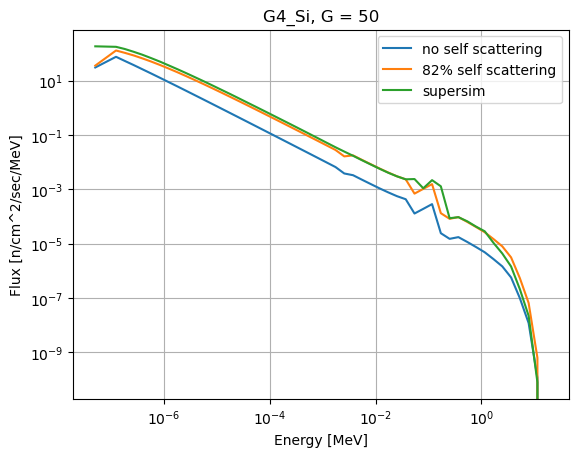

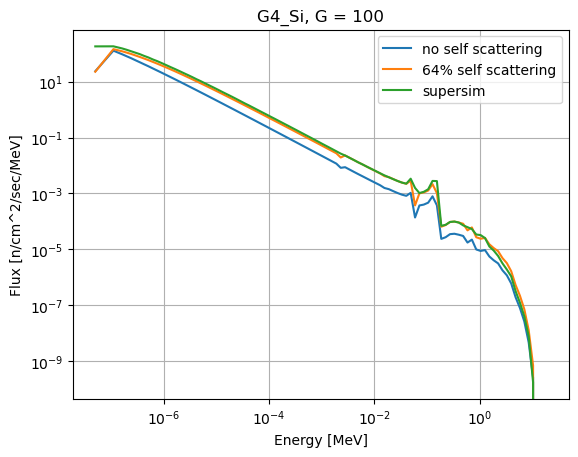

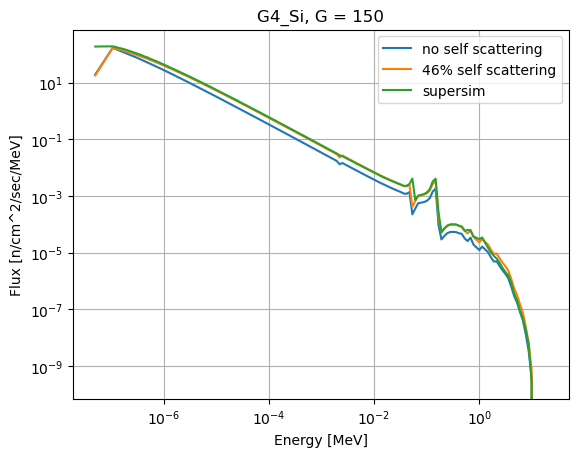

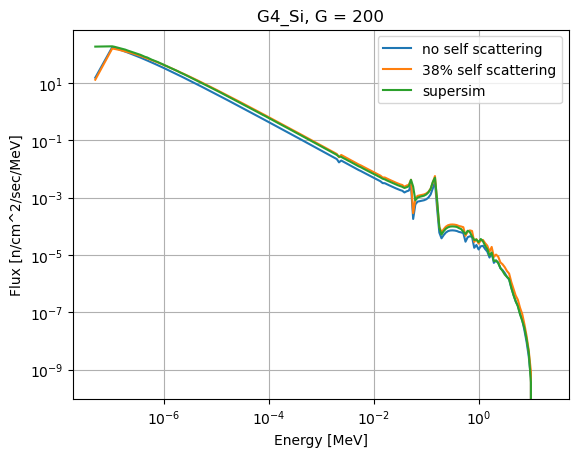

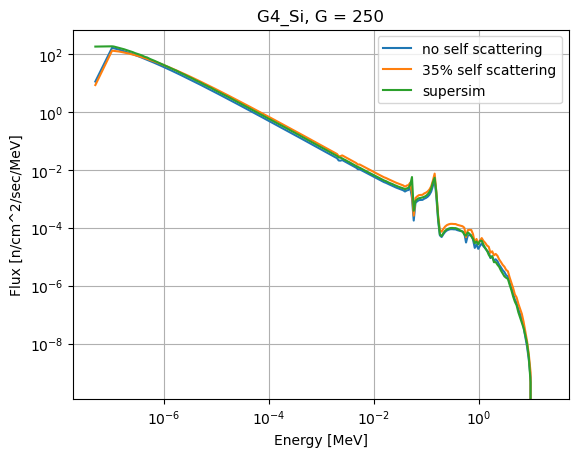

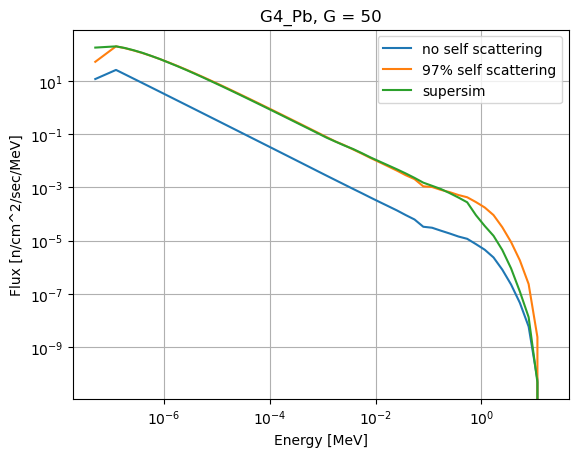

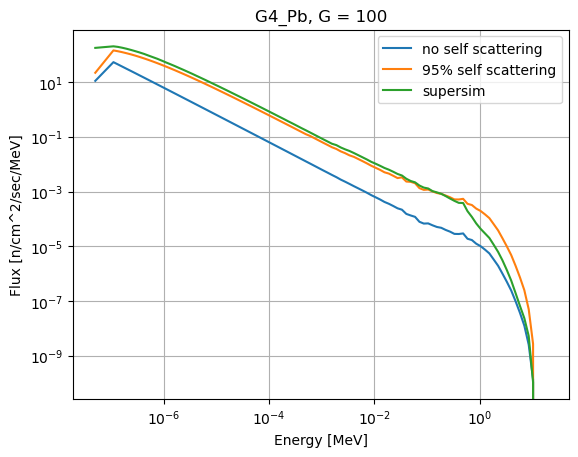

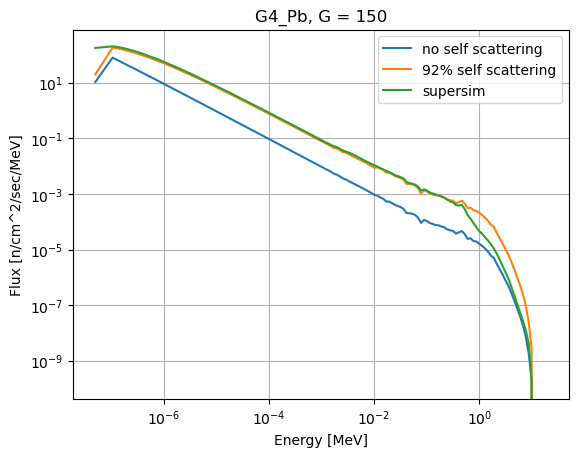

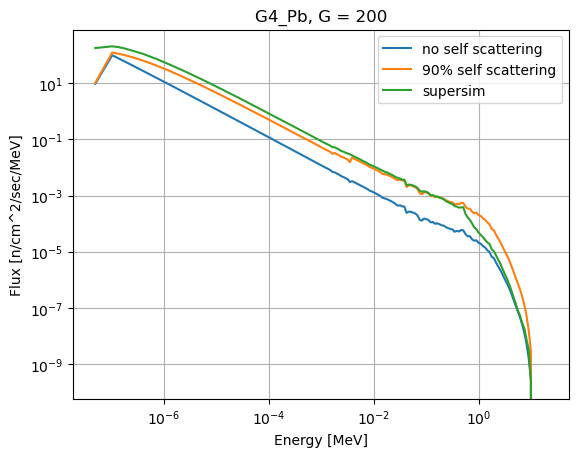

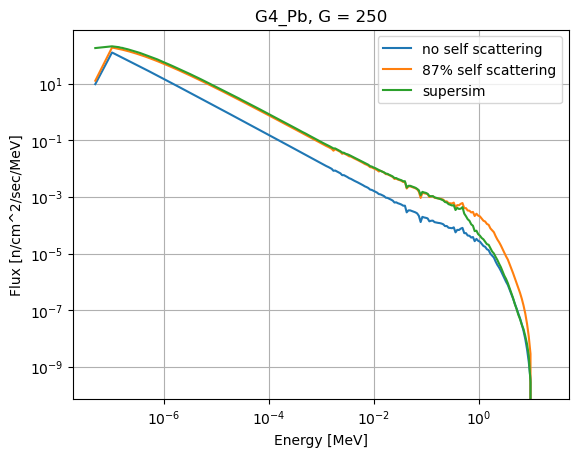

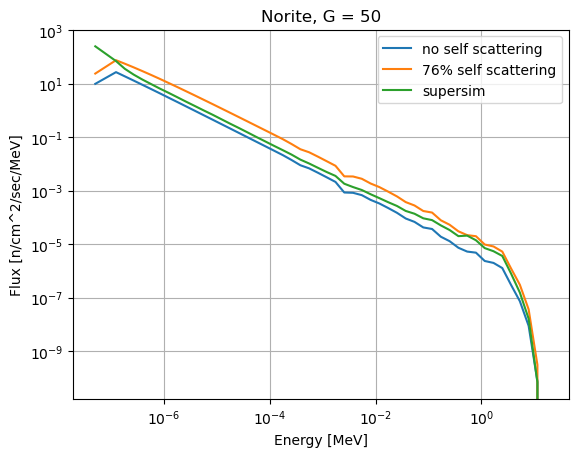

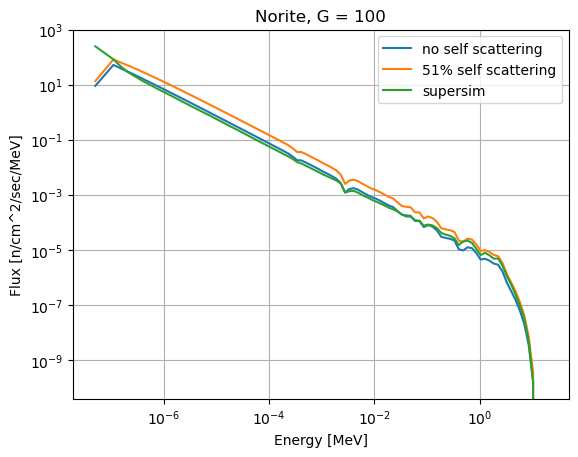

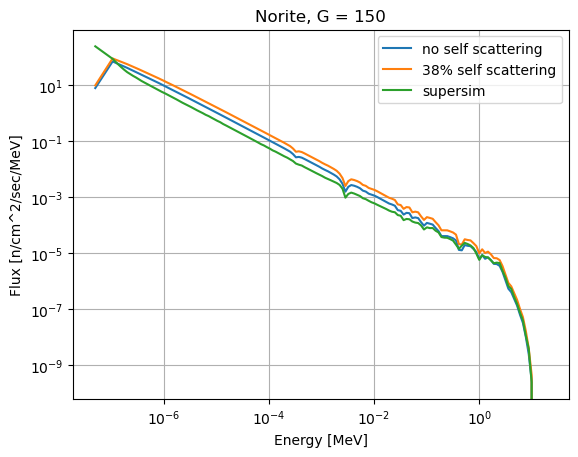

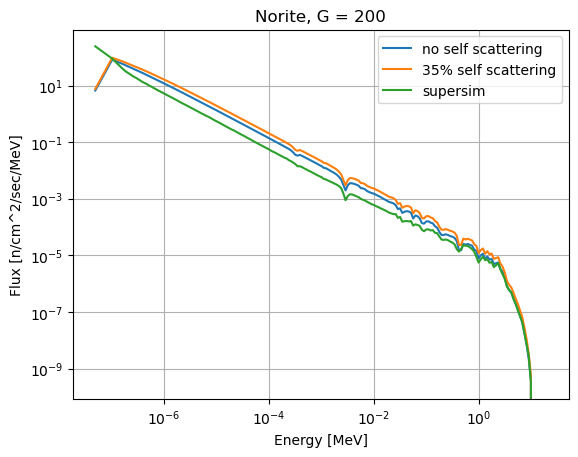

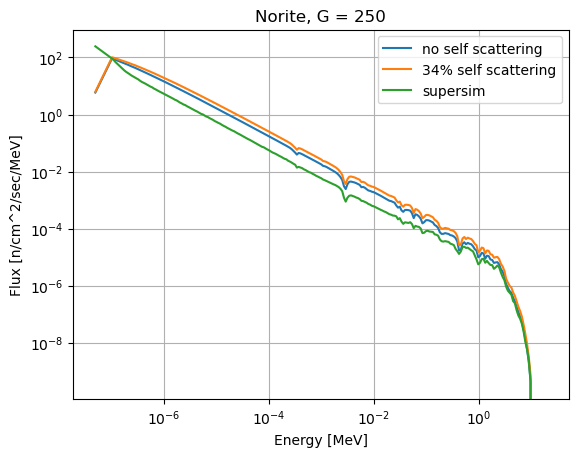

In [68]:
Gs= {'Norite': (50, 100, 150, 200, 250),
     'G4_Si': (50, 100, 150, 200, 250),
     'G4_Pb': (50, 100, 150, 200, 250)}

total_fluxes = pd.DataFrame([(key, entry) for key in Gs for entry in Gs[key]], columns = ('mat','G'))

for mat in ('G4_Si', 'G4_Pb', 'Norite'):

    A = A_vals[mat]
    alpha = ((A-1)/(A+1))**2
    
    for G in Gs[mat]:

        beta = (EG/E0)**(1/G)

        q = get_q(alpha, beta)
        
        XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'x_t'])
        Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
        BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = BC.Eg.values
        Es = (Eg[1:] + Eg[:-1])/2
        dE = abs(Eg[1:] - Eg[:-1])

        xs = XS.x_s.values
        xt = XS.x_t.values
        Sg = Src.Sg.values
        Eg = XS.Eg.values
        phig = BC.phig.values


        plt.figure()
        plt.grid()
        plt.loglog()
        plt.xlabel('Energy [MeV]')
        plt.ylabel('Flux [n/cm^2/sec/MeV]')
        plt.title(f'{mat}, G = {G}')

        phi2 = calc_bc((1-q)*xs, xt - q*xs, Sg)

        

        ss_data_file = 'data/SuperSim_estimates/phi_calcs' + ('' if mat == 'Norite' else mat[2:]) + f'_{G}.dat'
        ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])
        Eg_s = ss_dat.Eg.values
        phig_s = ss_dat.phig.values

        plt.plot(*plottable_spectrum(Eg, phig), label = 'no self scattering')
        plt.plot(*plottable_spectrum(Eg, phi2), label = f'{100*q:.0f}% self scattering')
        plt.plot(*plottable_spectrum(Eg_s, phig_s), label = 'supersim')

        plt.legend()

        i = (total_fluxes['mat'] == mat) & (total_fluxes['G'] == G)
        total_fluxes.at[i, 'no_ss'] = trap_plottable(Eg, phig)
        total_fluxes.at[i, 'w_ss'] = trap_plottable(Eg, phi2)
        total_fluxes.at[i, 'supersim'] = trap_plottable(Eg_s, phig_s)
        total_fluxes.at[i, 'supersim_uncertainty'] = trap_plottable(Eg_s, ss_dat.dphig.values)

        f1 = trap_plottable(Eg, phig)
        f2 = trap_plottable_old(Eg, phig)
        print((f2 - f1)/f1)

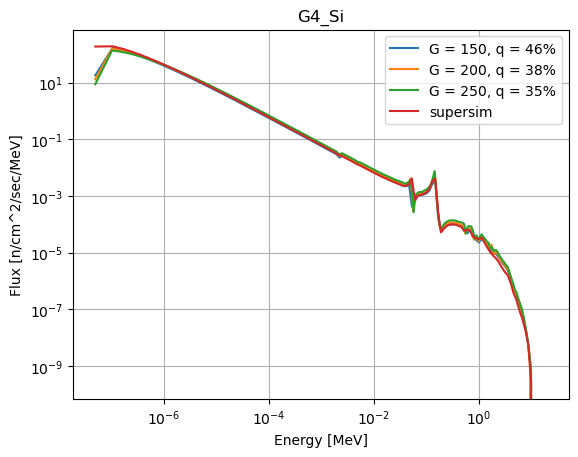

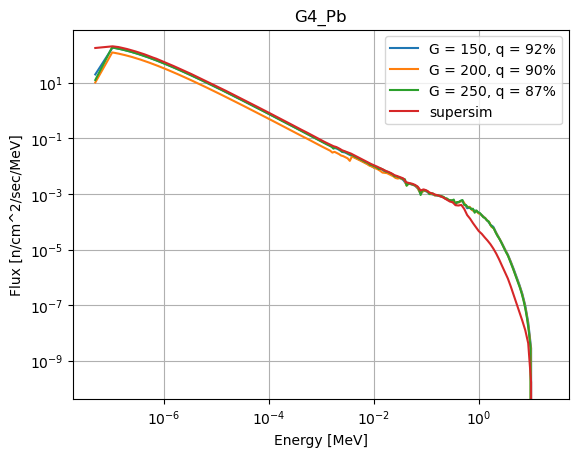

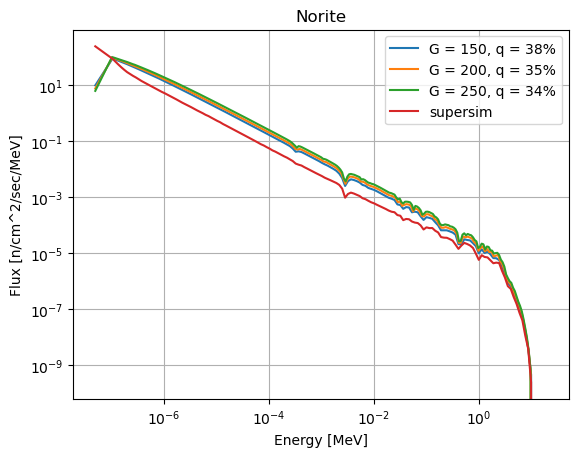

In [69]:
# plot self-scattering corrected terms

for mat in ('G4_Si', 'G4_Pb', 'Norite'):

    mat_str_add = '' if mat == 'Norite' else mat[2:]

    A = A_vals[mat]
    alpha = ((A-1)/(A+1))**2

    ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + '_150.dat'
    ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Flux [n/cm^2/sec/MeV]')
    plt.title(mat)

    for G in [150, 200, 250]:        

        XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'x_t'])
        Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
        BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = BC.Eg.values
        Es = (Eg[1:] + Eg[:-1])/2
        dE = abs(Eg[1:] - Eg[:-1])

        xs = XS.x_s.values
        xt = XS.x_t.values
        Sg = Src.Sg.values
        Eg = XS.Eg.values
        phig = BC.phig.values

        beta = (EG/E0)**(1/G)

        q = get_q(alpha, beta)
        
        phi2 = calc_bc((1-q)*xs, xt - q*xs, Sg)

        plt.plot(*plottable_spectrum(Eg, phi2), label = f'G = {G}, q = {100*q:.0f}%')

    Eg_s, phig_s = plottable_spectrum(ss_dat.Eg.values, ss_dat.phig.values)
    ss_plot = plt.plot(Eg_s, phig_s, label = 'supersim')
    #plt.fill_between(Eg_s, phig_s - dphig_s, phig_s + dphig_s, alpha =  0.5, color = ss_plot[0].get_color())
    #plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

    plt.legend()

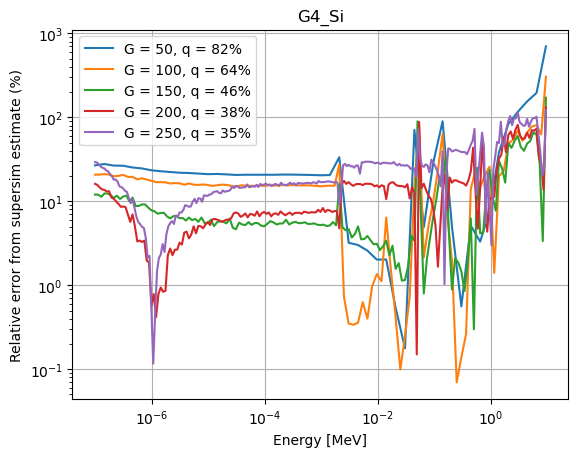

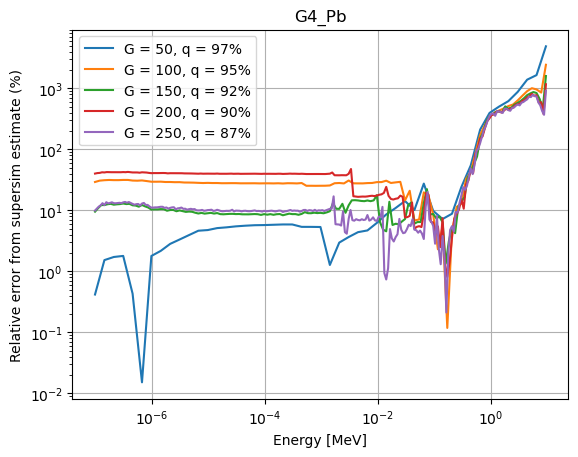

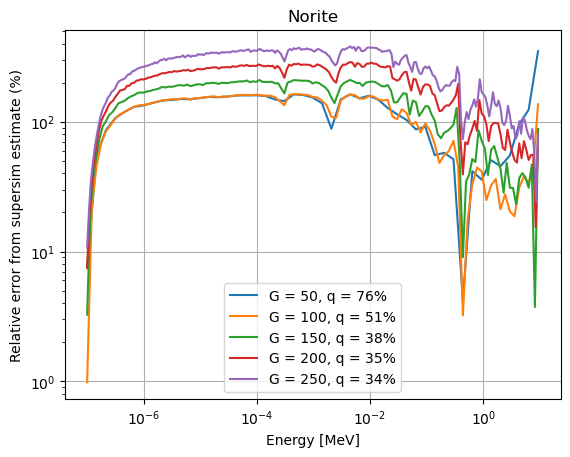

In [75]:
# plot self-scattering corrected terms

for mat in ('G4_Si', 'G4_Pb', 'Norite'):

    mat_str_add = '' if mat == 'Norite' else mat[2:]

    A = A_vals[mat]
    alpha = ((A-1)/(A+1))**2

    plt.figure()
    plt.loglog()
    plt.grid()
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Relative error from supersim estimate (%)')
    plt.title(mat)
    

    for G in [50, 100, 150, 200, 250]:

        ss_data_file = 'data/SuperSim_estimates/phi_calcs' + mat_str_add + f'_{G}.dat'
        ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig', 'dphig'])

        Eg_s = ss_dat.Eg.values
        phig_s = ss_dat.phig.values
        dphig_s = ss_dat.dphig.values
        #ss_plot = plt.plot(Eg_s, phig_s, label = 'supersim')

        p = (phig_s[:-1] > 0)

        XS = pd.read_csv(f'../cross_sections/data/V1/data_{mat}_{G}_20_xs.dat', sep = ' ', index_col = 0, names = ['Eg', 'x_s', 'x_t'])
        Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])
        BC = pd.read_csv(f'../boundary_conditions/data/V1/data_{mat}_{G}_BC_V1.dat', sep = ' ', index_col = 0, names = ['Eg','phig'])

        Eg = BC.Eg.values
        Es = (Eg[1:] + Eg[:-1])/2
        dE = abs(Eg[1:] - Eg[:-1])

        xs = XS.x_s.values
        xt = XS.x_t.values
        Sg = Src.Sg.values
        Eg = XS.Eg.values
        phig = BC.phig.values

        beta = (EG/E0)**(1/G)

        q = get_q(alpha, beta)
        
        phi2 = calc_bc((1-q)*xs, xt - q*xs, Sg)

        #plt.plot(Eg[p], abs(phig - phig_s)[p]/phig_s[p], label = f'G = {G}, q = {100*q:.0f}%')
        plt.plot(Eg[:-1][p], 100*abs(phi2 - phig_s)[:-1][p]/phig_s[:-1][p], label = f'G = {G}, q = {100*q:.0f}%')

    plt.legend()

In [74]:
total_fluxes['err'] = (total_fluxes['w_ss'] - total_fluxes['supersim'])/total_fluxes['supersim']
total_fluxes

,mat,G,no_ss,w_ss,supersim,supersim_uncertainty,err
0,Norite,50,6.18410e-05,2.37805e-04,1.38211e-04,4.21202e-07,7.20588e-01
1,Norite,100,1.19807e-04,2.36446e-04,1.38211e-04,5.85130e-07,7.10759e-01
2,Norite,150,1.76214e-04,2.74885e-04,1.38211e-04,7.11041e-07,9.88873e-01
3,Norite,200,2.28334e-04,3.36033e-04,1.38211e-04,8.16907e-07,1.43130e+00
4,Norite,250,2.80474e-04,4.08513e-04,1.38211e-04,9.10682e-07,1.95572e+00
5,G4_Si,50,1.89006e-04,8.10687e-04,1.07372e-03,2.41308e-06,-2.44974e-01
6,G4_Si,100,3.75865e-04,8.83413e-04,1.07372e-03,3.26991e-06,-1.77241e-01
7,G4_Si,150,5.71000e-04,9.74987e-04,1.07372e-03,3.90512e-06,-9.19541e-02
8,G4_Si,200,7.54248e-04,1.12540e-03,1.07372e-03,4.50478e-06,4.81319e-02
9,G4_Si,250,8.81527e-04,1.23237e-03,1.07372e-03,4.99168e-06,1.47756e-01
